# Preliminary exploratory data analysis
### Loading Data and Dependencies

In [89]:
# import all dependencies
library(tidyverse)
library(tidymodels)
library(repr)
library(gridExtra)



# library(ggplot2)
# library(dplyr)
# library(patchwork)

# options(repr.matrix.max.rows = 6)

# create data dir and download csv into it
url <- "https://raw.githubusercontent.com/21chanas3/dsci100-group73/c9c58b88eca13be20286f8bf70dce4668b878247/data/healthcare-dataset-stroke-data.csv"
if (!dir.exists("data")) {
    dir.create("data") }
download.file(url, "data/stroke.csv")

stroke <- read_csv("data/stroke.csv")

Rows: 5110 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): gender, ever_married, work_type, Residence_type, bmi, smoking_status
dbl (6): id, age, hypertension, heart_disease, avg_glucose_level, stroke

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Cleaning and Wrangling

In [90]:
# rename columns to all lowercase
stroke_colnames <- stroke |> colnames() |> make.names() |> tolower()
colnames(stroke) <- stroke_colnames

# convert unknowns to NA
stroke <- stroke |> na_if("Unknown")

# convert categorical vars to factors
stroke <- stroke |> mutate(gender = as_factor(gender), 
                 work_type = as_factor(work_type), 
                 residence_type = as_factor(residence_type), 
                 smoking_status = as_factor(smoking_status),
                 hypertension = as_factor(hypertension),
                 ever_married = as_factor(ever_married),
                 heart_disease = as_factor(heart_disease),
                 stroke = as_factor(stroke))

# rename factor levels to nicer names
stroke$hypertension <- recode_factor(stroke$hypertension, "0" = "No", "1" = "Yes")
stroke$heart_disease <- recode_factor(stroke$heart_disease, "0" = "No", "1" = "Yes")
stroke$stroke <- recode_factor(stroke$stroke, "0" = "No", "1" = "Yes")
stroke$work_type <- recode_factor(stroke$work_type, "Govt_job" = "Government", "Never_worked" = "Never Worked")
stroke$smoking_status <- recode_factor(stroke$smoking_status, "formerly smoked" = "Formerly", "never smoked" = "Never", "smokes" = "Smokes")

# for some reason bmi is of type char probably because of N/A, converting to double here
stroke <- stroke |> mutate(bmi = as.numeric(as.character(bmi)))

# # drop variables/columns that we are not using to train - see Methodology section for more details
# stroke <- stroke |> subset(select = -c(id, ever_married,work_type))


Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


# Preliminary analysis
To begin our analysis, we employed the ggpairs tool, enabling us to gain a holistic view of the dataset and its clinical variables. By generating a matrix where each variable was plotted against one another with whether a patient had a stroke before, we could visually identify variables that had correlations with one another or with stroke. Consequently, this provided us with valuable insights into the variables that needed further investigation below and those that could be excluded due to their lack of significance in our analysis.

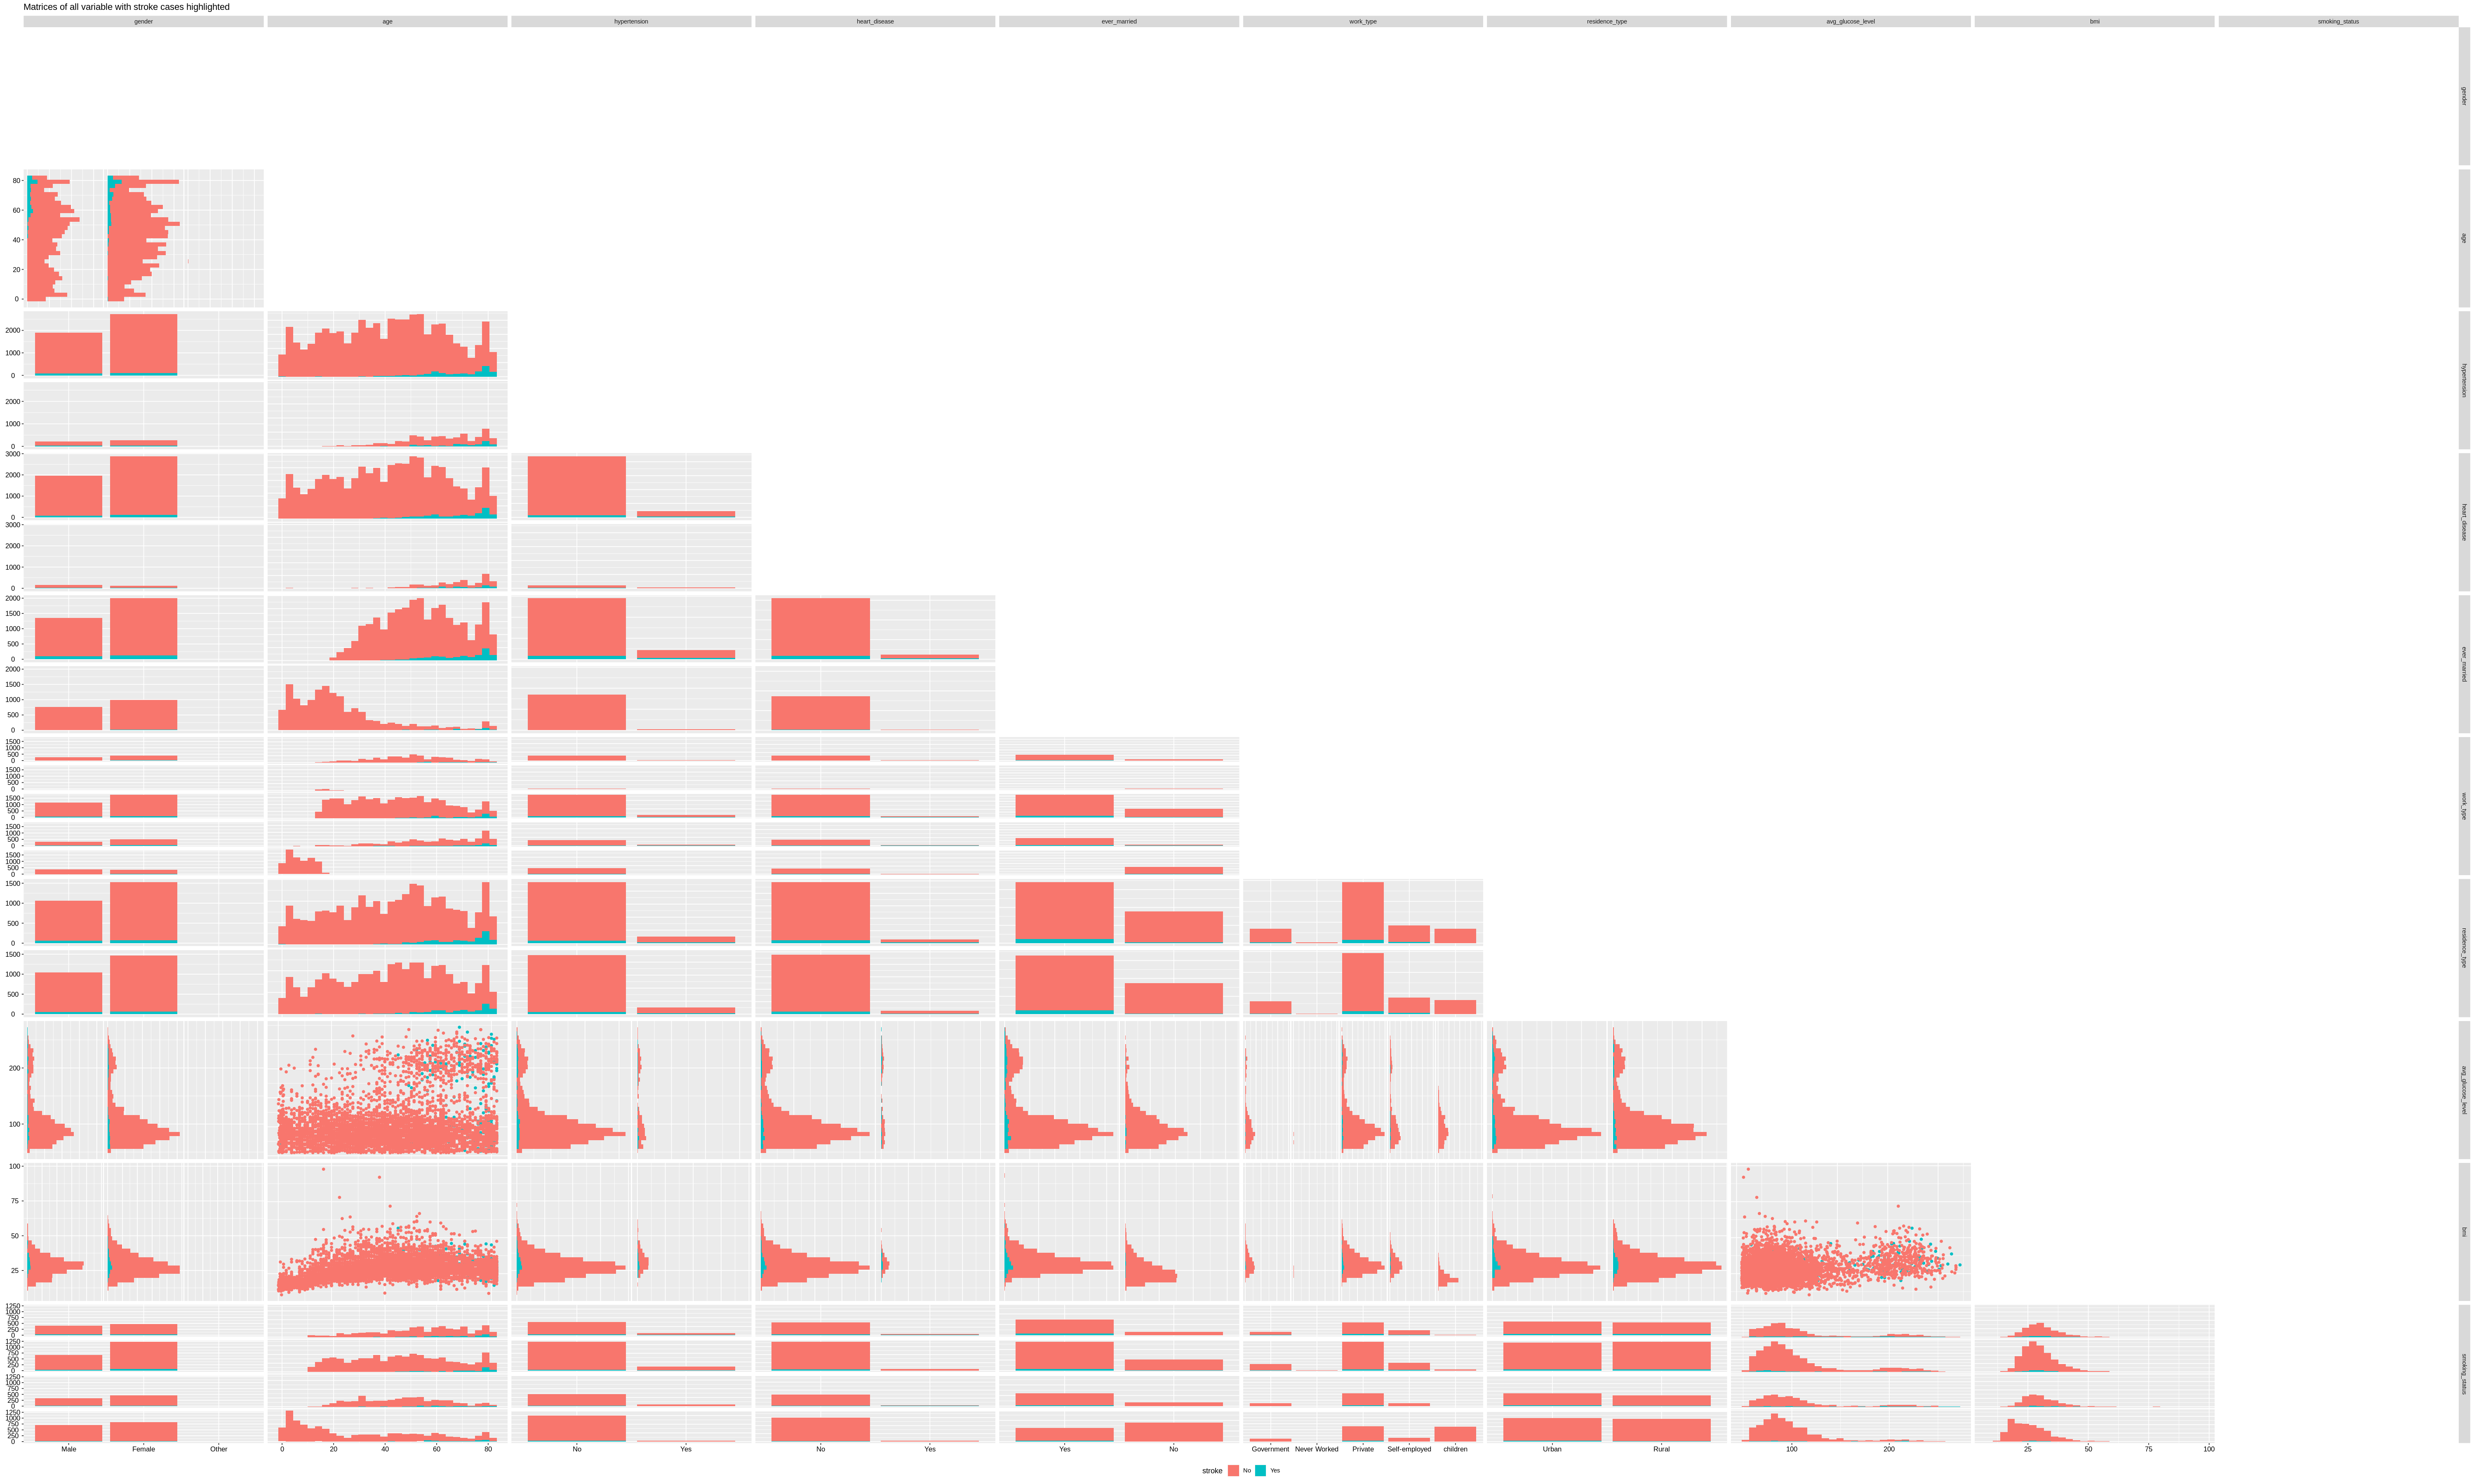

In [91]:
library(GGally)
options(repr.plot.width = 50, repr.plot.height = 30) 

plot_pairs <- stroke |>   
  ggpairs(legend=11,
          columns=2:11,
          mapping = ggplot2::aes(color = stroke),
          upper="blank",
          diag = NULL)+


          labs(color="Verification")+

          ggtitle("Matrices of all variable with stroke cases highlighted") +

          theme(plot.title = element_text(hjust = 0),
                axis.text.x = element_text(hjust = .5, color = "black", size=10),
                axis.text.y = element_text(hjust = .5, color = "black",size=10),
                legend.position = "bottom")
    
suppressMessages(suppressWarnings(print(plot_pairs)))

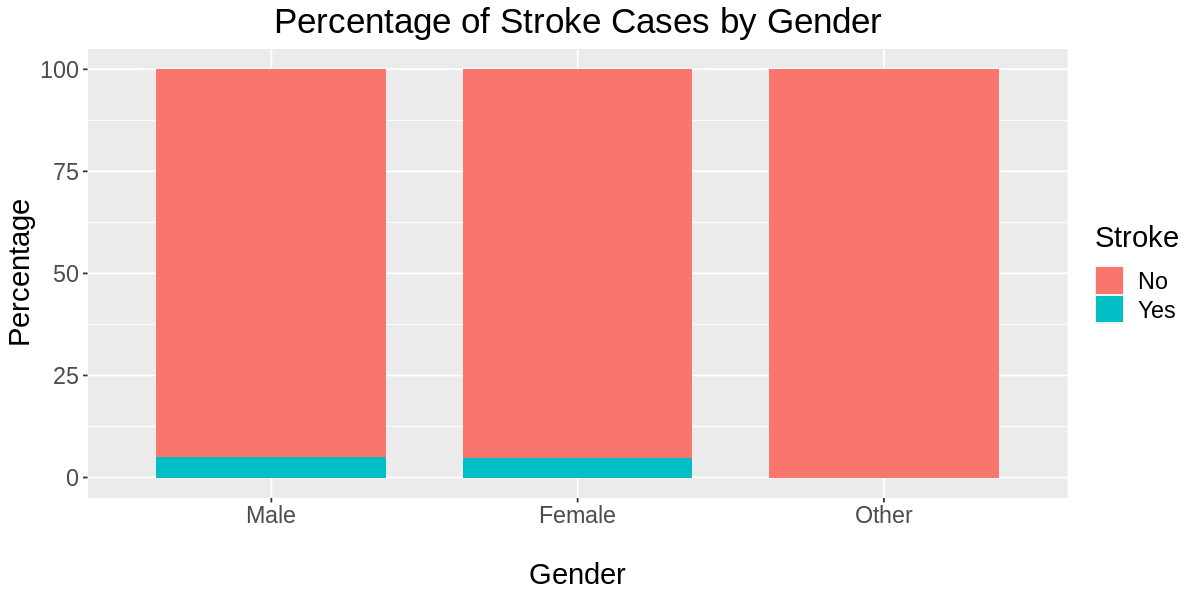

In [92]:
options(repr.plot.width = 10, repr.plot.height = 5) 

stroke_gender <- stroke |>
  count(gender, stroke) |>
  group_by(gender) |>
  mutate(percentage = n / sum(n) * 100) |>
  ggplot(aes(x = gender, y = percentage, fill = stroke)) +
  geom_bar(stat = "identity", width = .75) +
  labs(x = "\nGender", y = "Percentage", fill = "Stroke", title = "Percentage of Stroke Cases by Gender") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5))
stroke_gender

There was no difference between males and females in terms of the number of stroke cases.

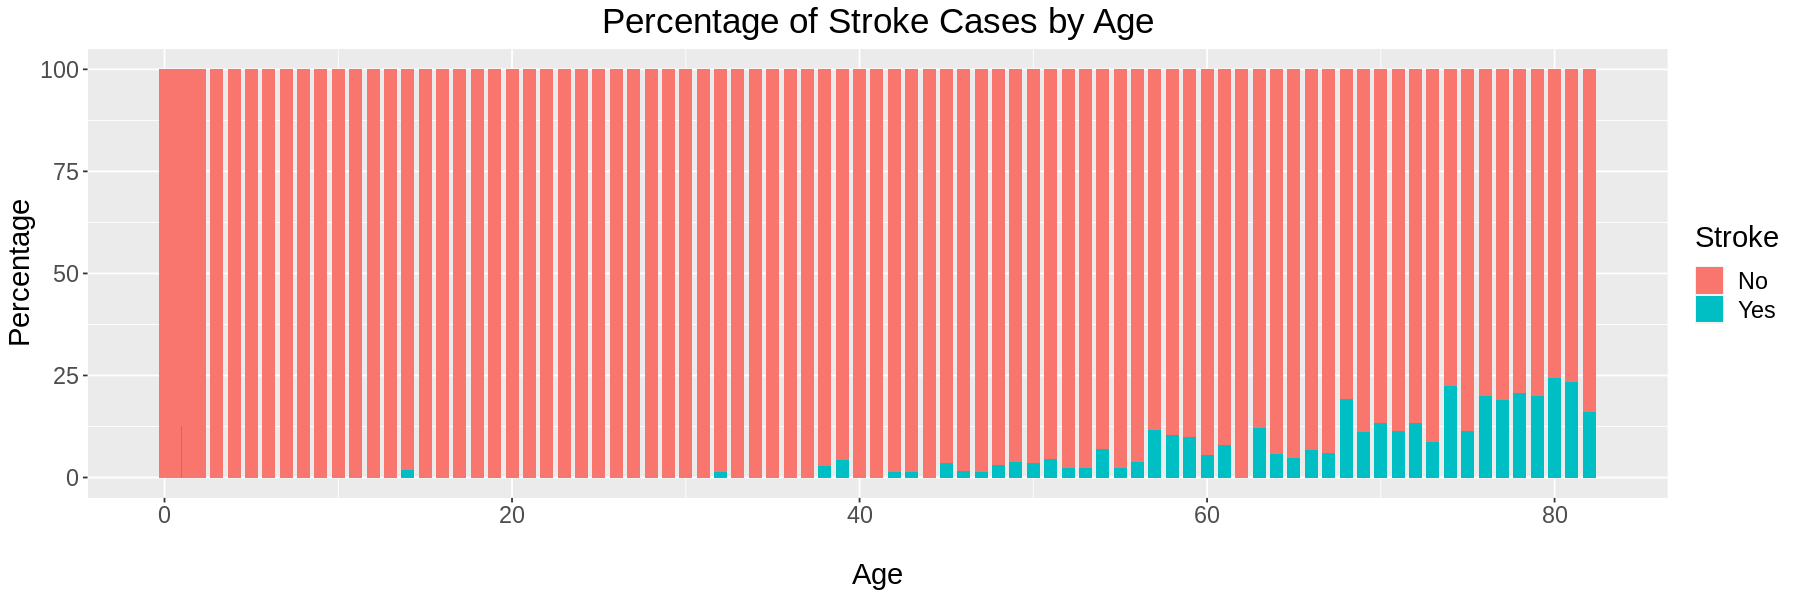

In [93]:
options(repr.plot.width = 15, repr.plot.height = 5) 

stroke_age <- stroke |>
  count(age, stroke) |>
  group_by(age) |>
  mutate(percentage = n / sum(n) * 100) |>
  ggplot(aes(x = age, y = percentage, fill = stroke)) +
  geom_bar(stat = "identity", width = .75) +
  labs(x = "\nAge", y = "Percentage", fill = "Stroke", title = "Percentage of Stroke Cases by Age") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5))
suppressWarnings(print(stroke_age))

With regards to age, quite significantly less than 12.5% of the patients under 40 years of age had suffered a stroke. Between the ages of 40 and 50, the number of cases rose to just under 12.5%. Between the ages of 50 and 60, we start to see those cases rise to greater than 12.5% but stay under 25%. However, once participants past their early 60s, we see a somewhat substantial increase in the number of cases, up to, and in a few age groups, greater than 25%. The data suggests that those who are above the age of 60 are roughly twice as likely to suffer a stroke than those who are in their mid to late 40s.

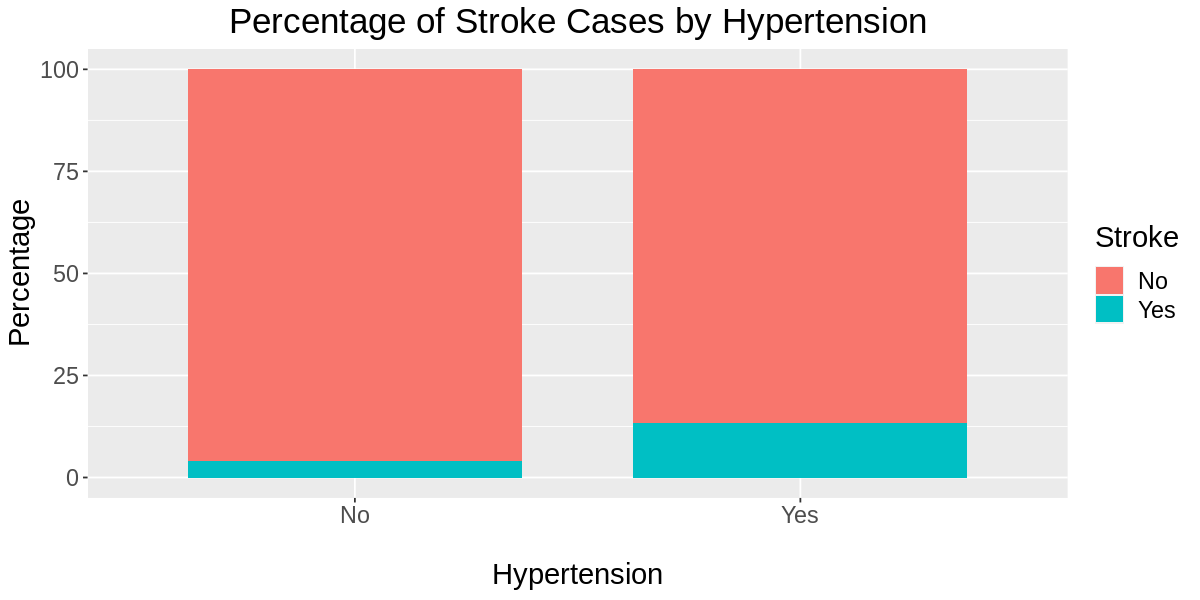

In [94]:
options(repr.plot.width = 10, repr.plot.height = 5) 

stroke_hypertension <- stroke |>
  count(hypertension, stroke) |>
  group_by(hypertension) |>
  mutate(percentage = n / sum(n) * 100) |>
  ggplot(aes(x = hypertension, y = percentage, fill = stroke)) +
  geom_bar(stat = "identity", width = .75) +
  labs(x = "\nHypertension", y = "Percentage", fill = "Stroke", title = "Percentage of Stroke Cases by Hypertension") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5))
stroke_hypertension

Those who have suffered hypertension are roughly twice as likely to have a stroke, which is around 12.5% of the cases.

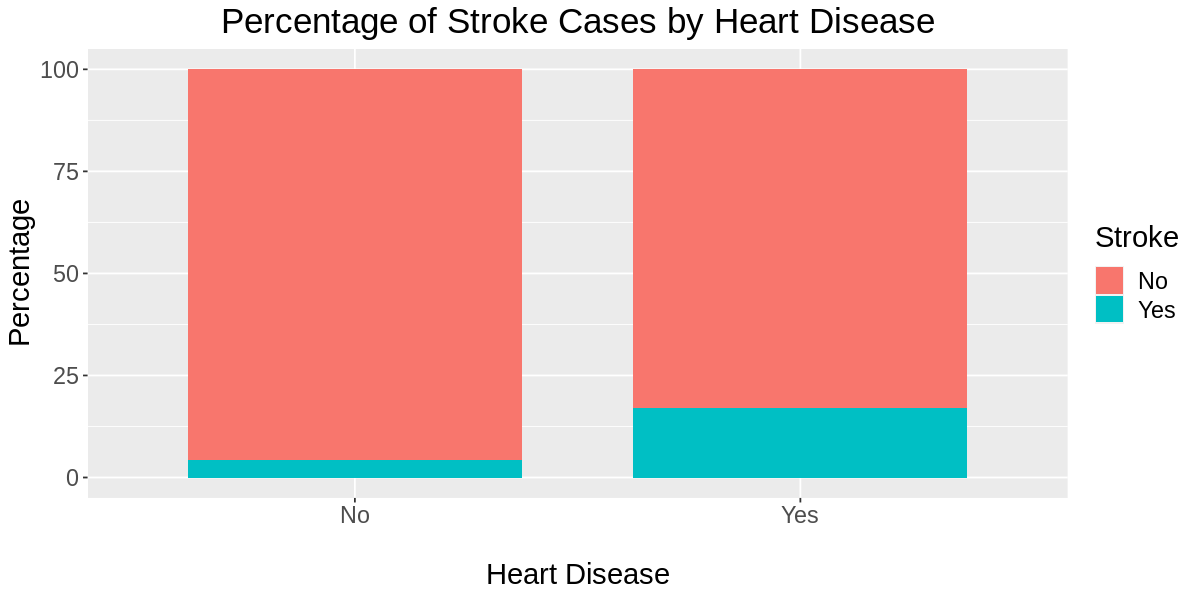

In [95]:
options(repr.plot.width = 10, repr.plot.height = 5) 

stroke_heart_disease <- stroke %>%
  count(heart_disease, stroke) %>%
  group_by(heart_disease) %>%
  mutate(percentage = n / sum(n) * 100) %>%
  ggplot(aes(x = heart_disease, y = percentage, fill = stroke)) +
  geom_bar(stat = "identity", width = .75) +
  labs(x = "\nHeart Disease", y = "Percentage", fill = "Stroke", title = "Percentage of Stroke Cases by Heart Disease") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5))
stroke_heart_disease

Those who have suffered heart disease are roughly twice as likely to have a stroke, which is around 20-25% of the cases.

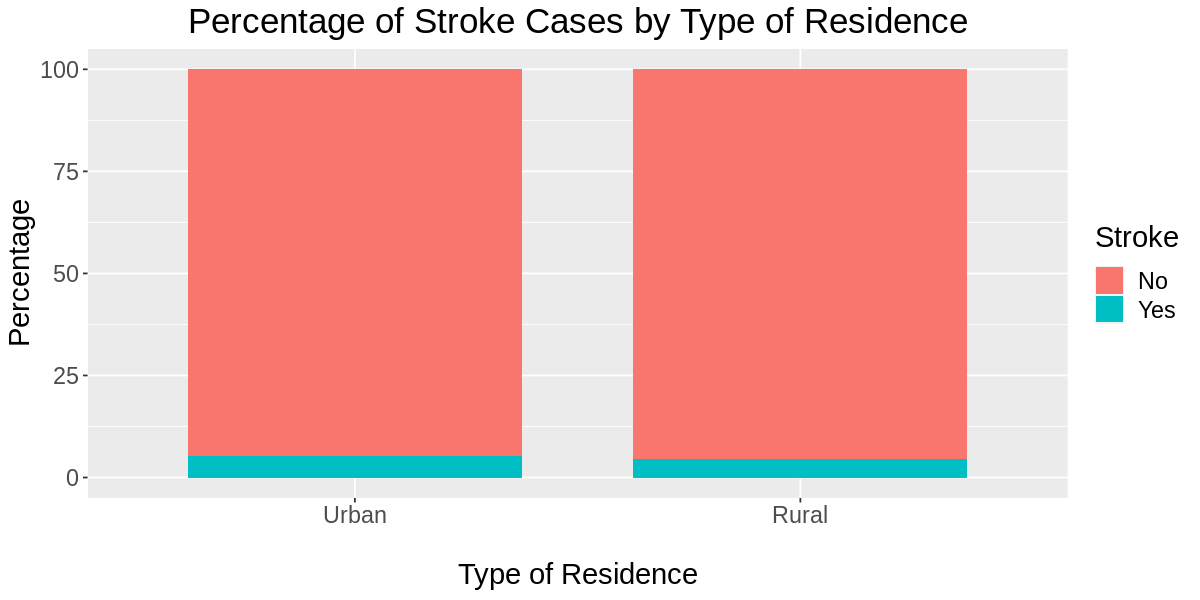

In [96]:
options(repr.plot.width = 10, repr.plot.height = 5) 

stroke_residence <- stroke %>%
  count(residence_type, stroke) %>%
  group_by(residence_type) %>%
  mutate(percentage = n / sum(n) * 100) %>%
  ggplot(aes(x = residence_type, y = percentage, fill = stroke)) +
  geom_bar(stat = "identity", width = .75) +
  labs(x = "\nType of Residence", y = "Percentage", fill = "Stroke", title = "Percentage of Stroke Cases by Type of Residence") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5))
stroke_residence

There is no difference between those who live in urban areas and those who live in more rural areas and their likelihood of getting a stroke.

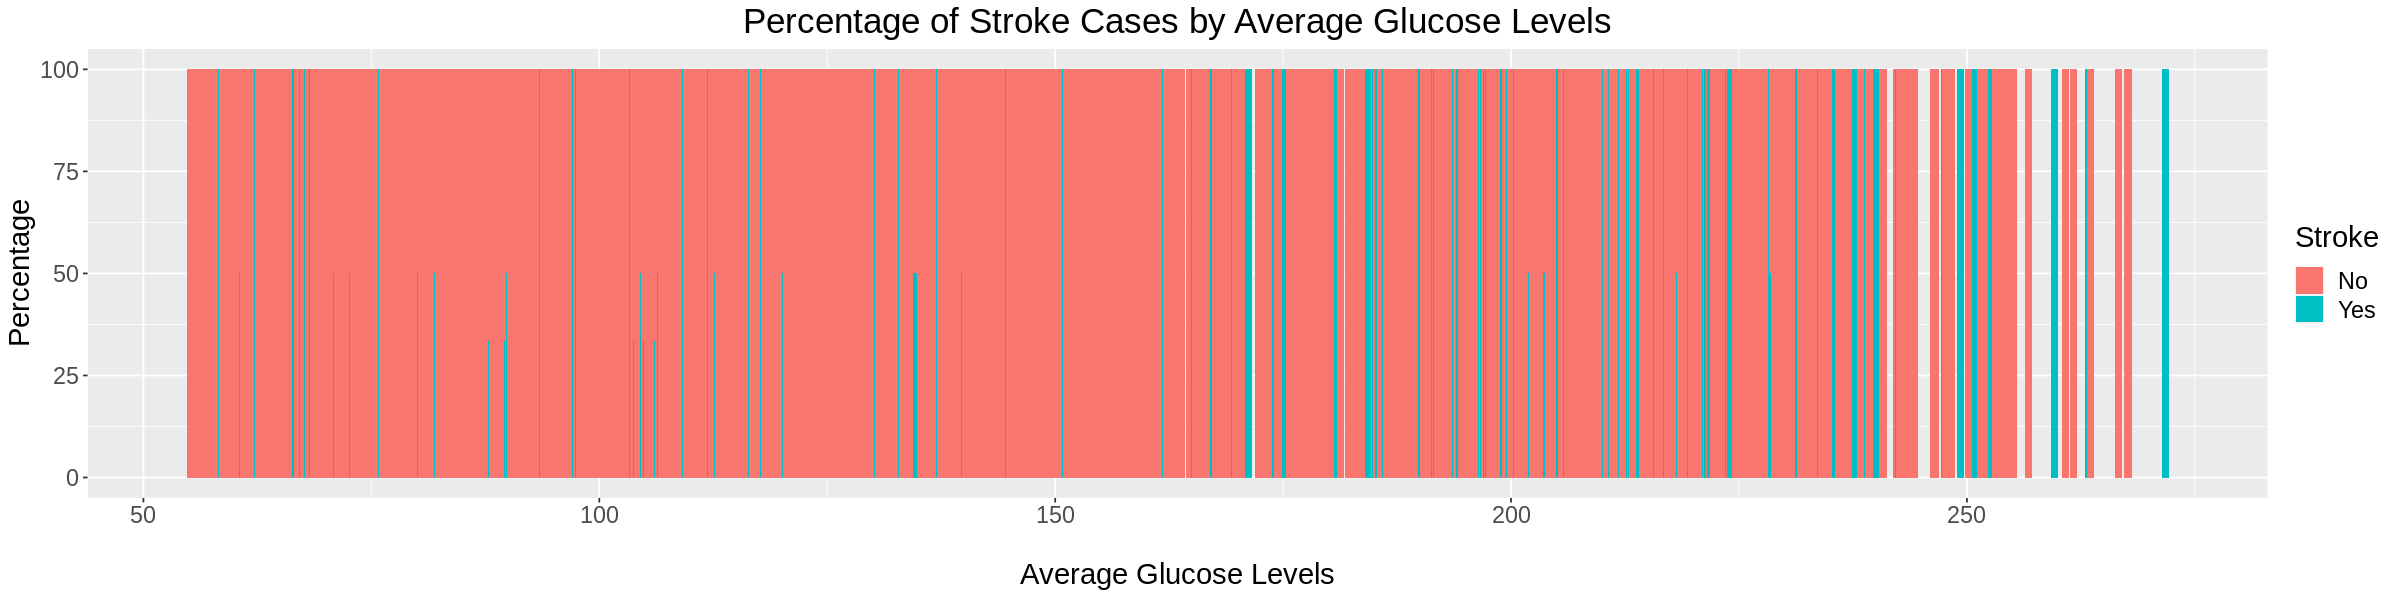

In [97]:
options(repr.plot.width = 20, repr.plot.height = 5) 

stroke_avg_glucose_level <- stroke %>%
  count(avg_glucose_level, stroke) %>%
  group_by(avg_glucose_level) %>%
  mutate(percentage = n / sum(n) * 100) %>%
  ggplot(aes(x = avg_glucose_level, y = percentage, fill = stroke)) +
  geom_bar(stat = "identity", width = .75) +
  labs(x = "\nAverage Glucose Levels", y = "Percentage", fill = "Stroke", title = "Percentage of Stroke Cases by Average Glucose Levels") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5))
suppressWarnings(print(stroke_avg_glucose_level))

There is an association between stroke cases and average glucose levels, as the higher the average glucose level, the greater the frequency of a participant having had a stroke.

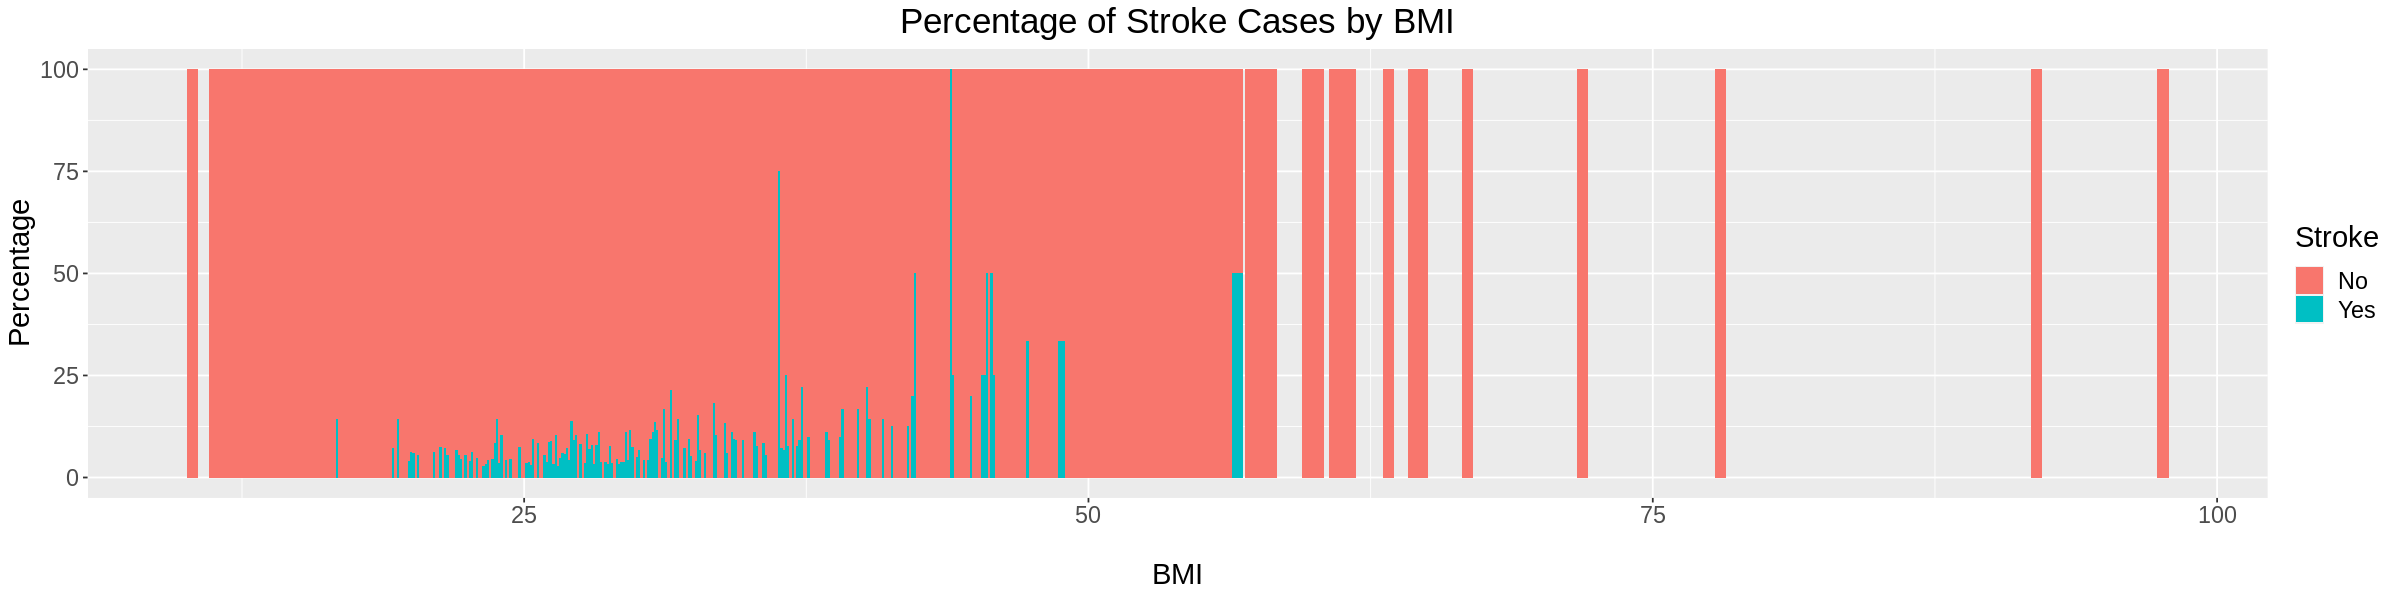

In [98]:
options(repr.plot.width = 20, repr.plot.height = 5) 

stroke_bmi <- stroke %>%
  count(bmi, stroke) %>%
  group_by(bmi) %>%
  mutate(percentage = n / sum(n) * 100) %>%
  ggplot(aes(x = bmi, y = percentage, fill = stroke)) +
  geom_bar(stat = "identity", width = .5) +
  labs(x = "\nBMI", y = "Percentage", fill = "Stroke", title = "Percentage of Stroke Cases by BMI") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5))
suppressWarnings(print(stroke_bmi))

There is a link between BMI and strokes. According to our analysis, we start to see a positive linear relationship starting from a BMI of 20 to 40, and a percentage of stroke cases ranging from roughly 5% to 25%. Once we reach a BMI of 50 and above, we see numerous occasions where stroke cases rise to 50% or greater.

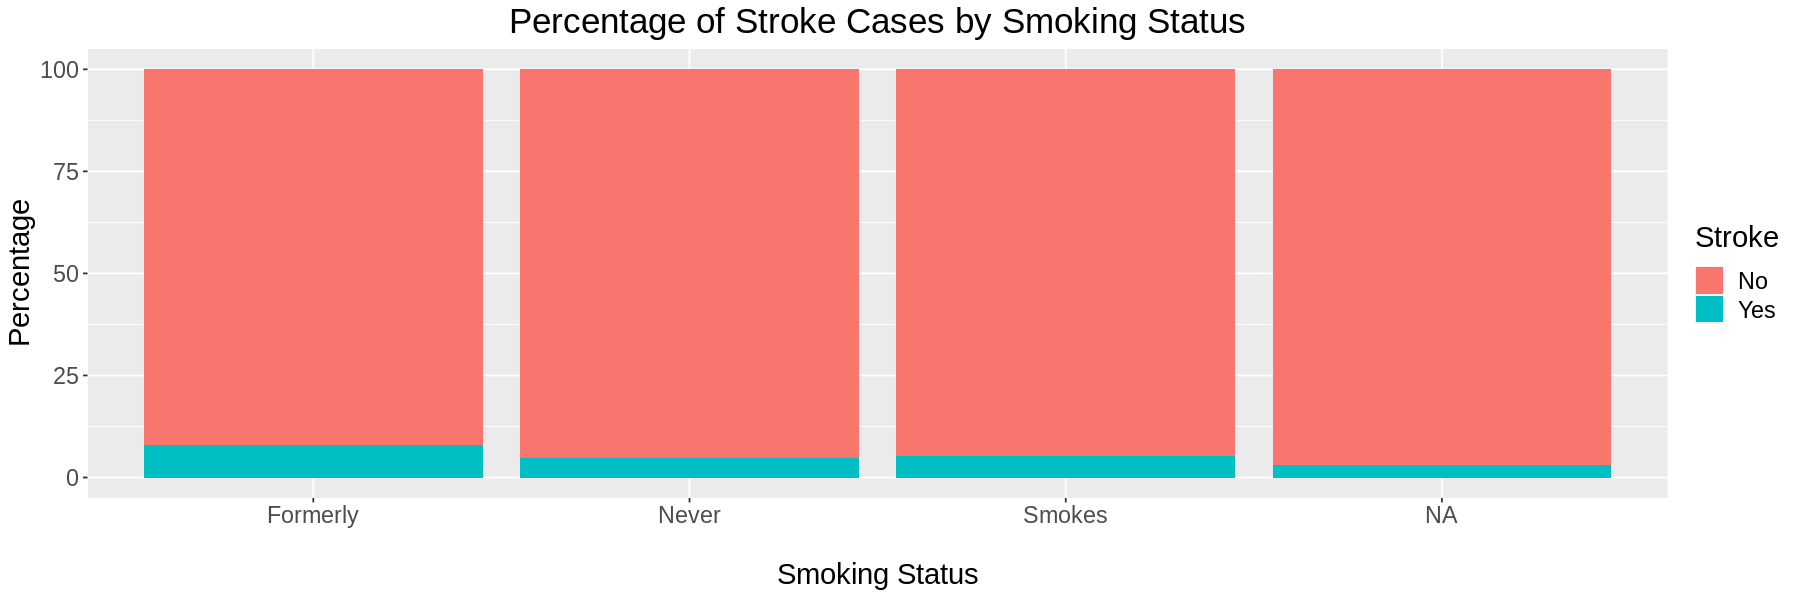

In [99]:
options(repr.plot.width = 15, repr.plot.height = 5) 

stroke_smoking_status <- stroke %>%
  count(smoking_status, stroke) %>%
  group_by(smoking_status) %>%
  mutate(percentage = n / sum(n) * 100) %>%
  ggplot(aes(x = smoking_status, y = percentage, fill = stroke)) +
  geom_bar(stat = "identity") +
  labs(x = "\nSmoking Status", y = "Percentage", fill = "Stroke", title = "Percentage of Stroke Cases by Smoking Status") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5))
stroke_smoking_status

The percentage of cases are quite similar between the three groups. However, those who have formerly smoked have a slightly higher risk of stroke than those who smoke. This may be due to current smokers being younger or having less overall damage than those who are former smokers. Potentially, those who are former smokers were heavy smokers which may explain why they quit smoking compared to those who currently smoke. Interestingly, those who have never smoked have the same likelihood of suffering a stroke as those who currently smoke. This means that other lifestyle factors could play a significant role in the risk of getting a stroke.

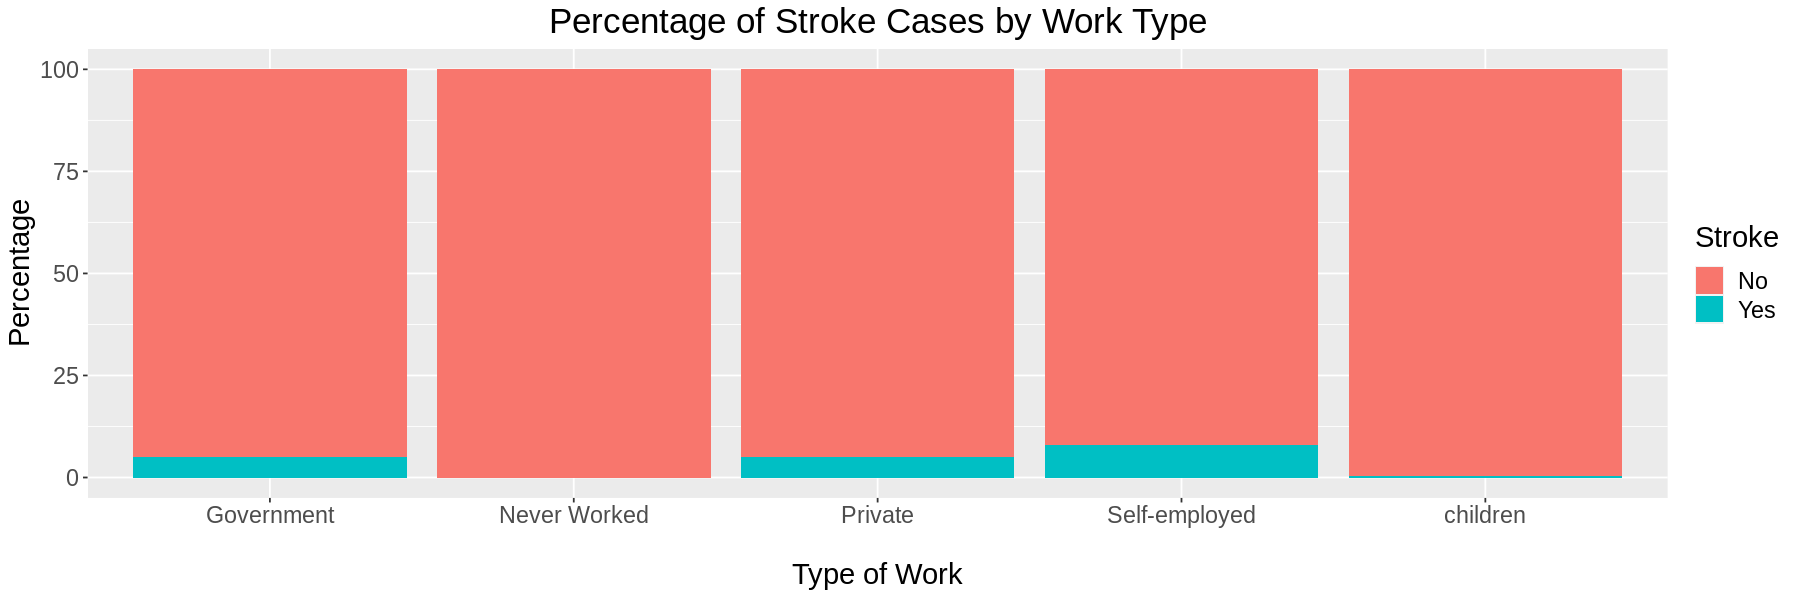

In [100]:
stroke_worktype_plot <- stroke |>
  count(work_type, stroke) |>
  group_by(work_type) |>
  mutate(percentage = n / sum(n) * 100) |>
  ggplot(aes(x = work_type, y = percentage, fill = stroke)) +
  geom_bar(stat = "identity") +
  labs(x = "\nType of Work", y = "Percentage", fill = "Stroke", title = "Percentage of Stroke Cases by Work Type") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5))
stroke_worktype_plot

Those who are self-employed are roughly twice as likely to suffer a stroke than those who work in government or in the private sector at around 20% of cases. This may be due to self employed potentially being in more incidents where their blood pressure is high due the uncertainties associated with being in that work type.

# Further Analysis

To further explore the relationships between stroke and various clinical variables, we conducted an analysis focusing on two key variables in relations to strokes. By examining their associations with stroke, we aimed to uncover potential interrelations and gain deeper insights into their significance.

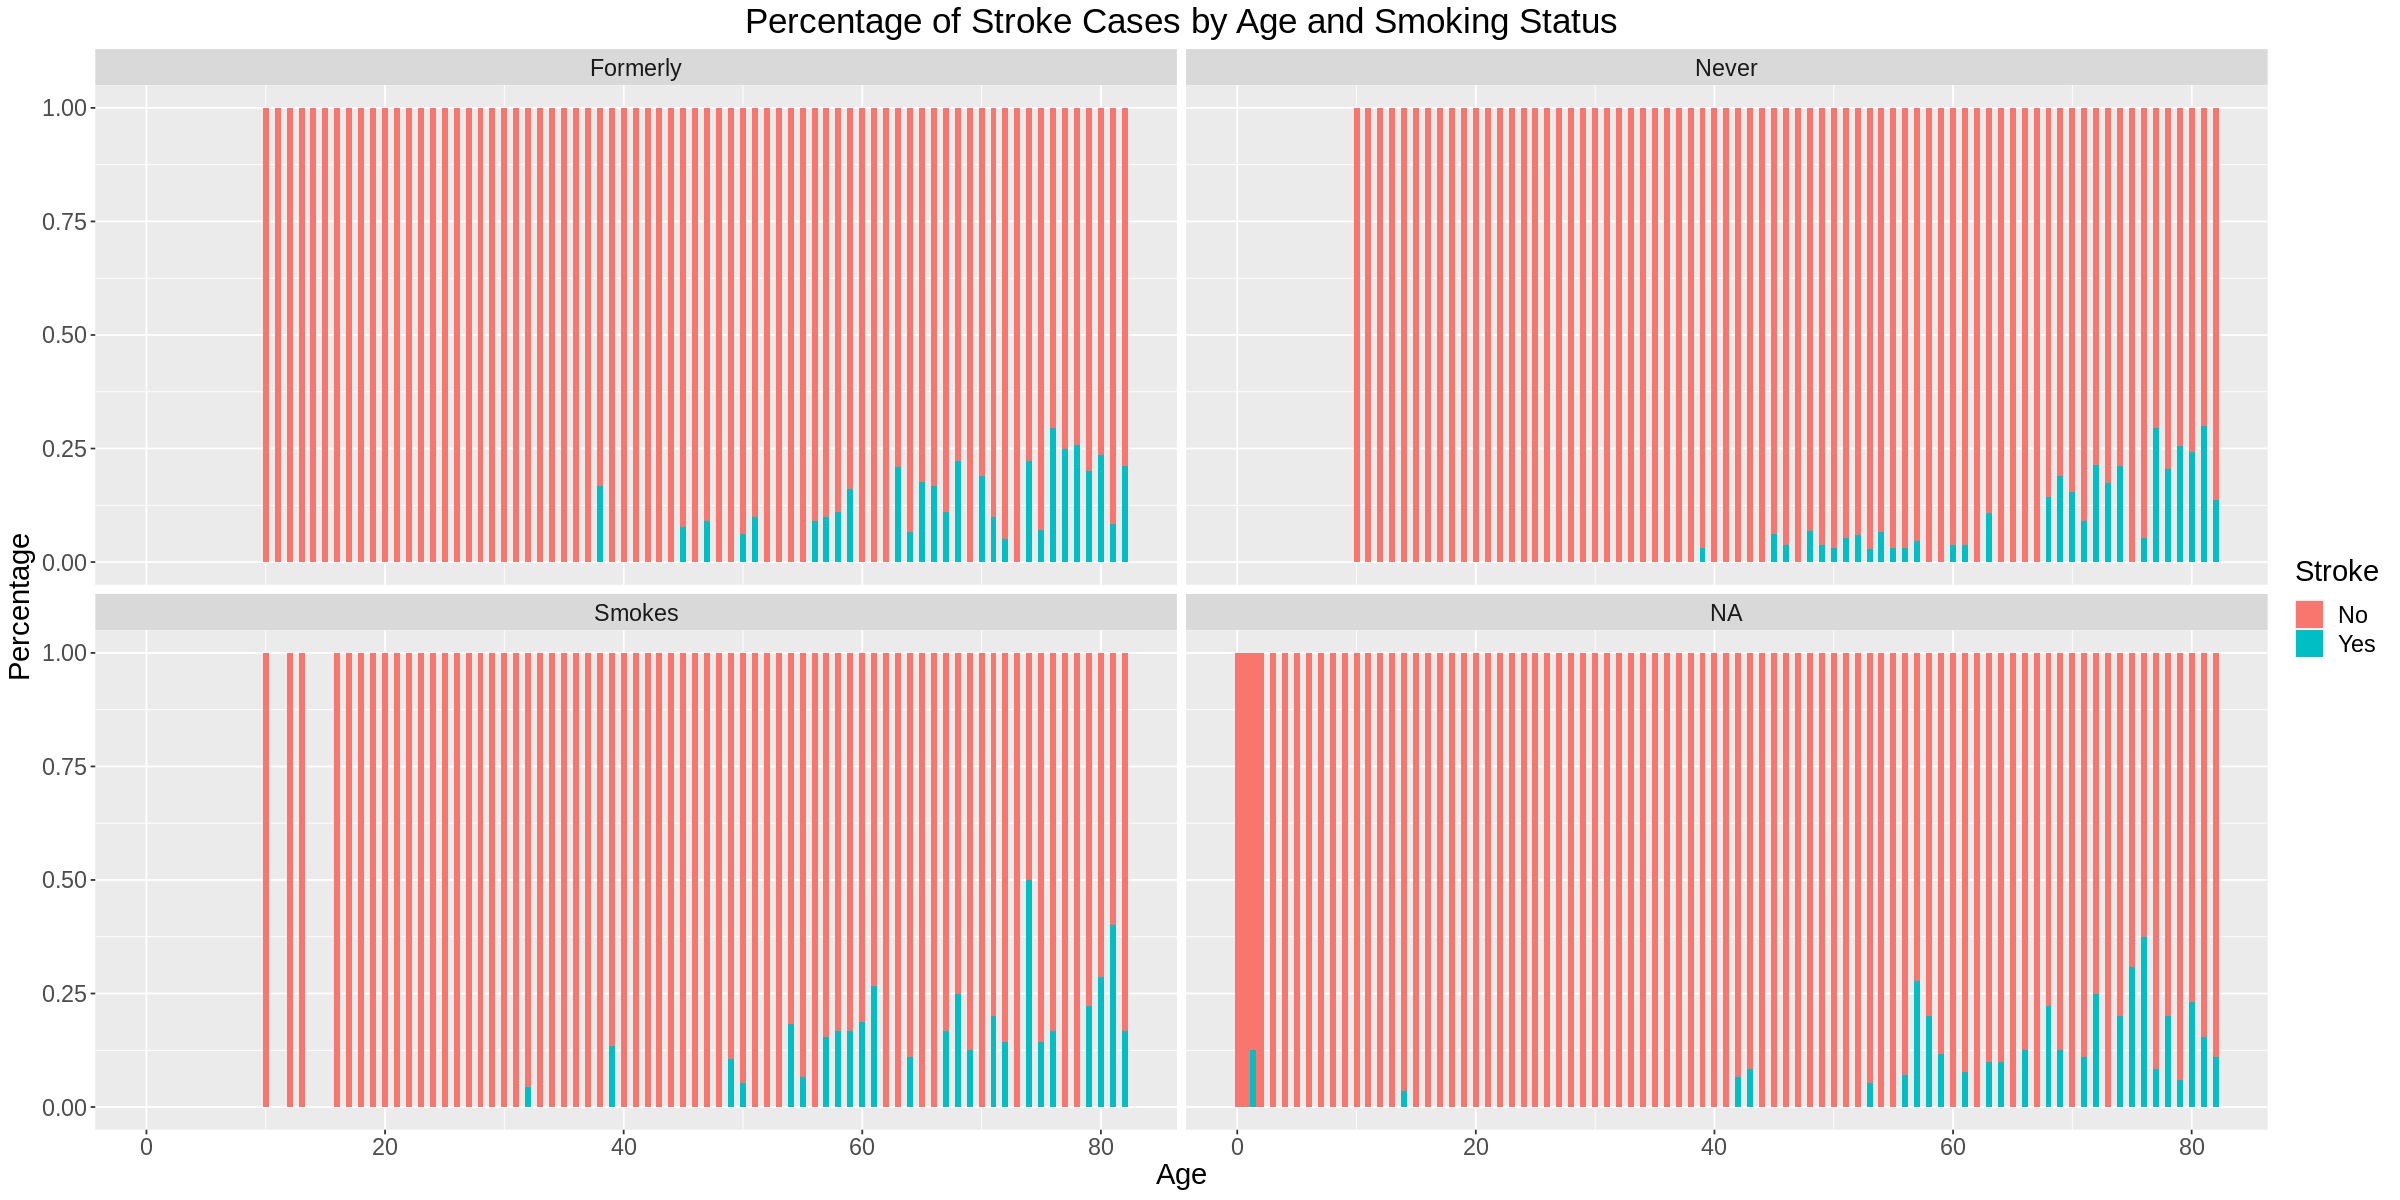

In [101]:
options(repr.plot.width = 20, repr.plot.height = 10) 

stroke_age_smoking <- stroke %>%
  ggplot(aes(x = age, fill = stroke)) +
  geom_bar(aes(y = ..count.. / sum(..count..)), position = "fill", width = .5) +
  facet_wrap(~ smoking_status) +
  labs(x = "Age", y = "Percentage", fill = "Stroke", title = "Percentage of Stroke Cases by Age and Smoking Status") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5))

suppressWarnings(print(stroke_age_smoking))

All smoking groups had roughly equal numbers of stroke cases with the common ground being that with age, there was an average increase in percentage of strokes. The main difference is that the peak percentage was highest in the group that currently “smokes” at around 50%. The “never” smoking and “formerly” smoking groups peaked at percentages between 40% to 50%. Interestingly, former smokers while had higher percentages than those who never smokes, they had lower percentages in comparison to current smokers, especially as age increase- this suggest a relationship that has been observed in the past where by stopping smoking for 5 years the risk of stroke reduced to that of a nonsmoker in most cases [].

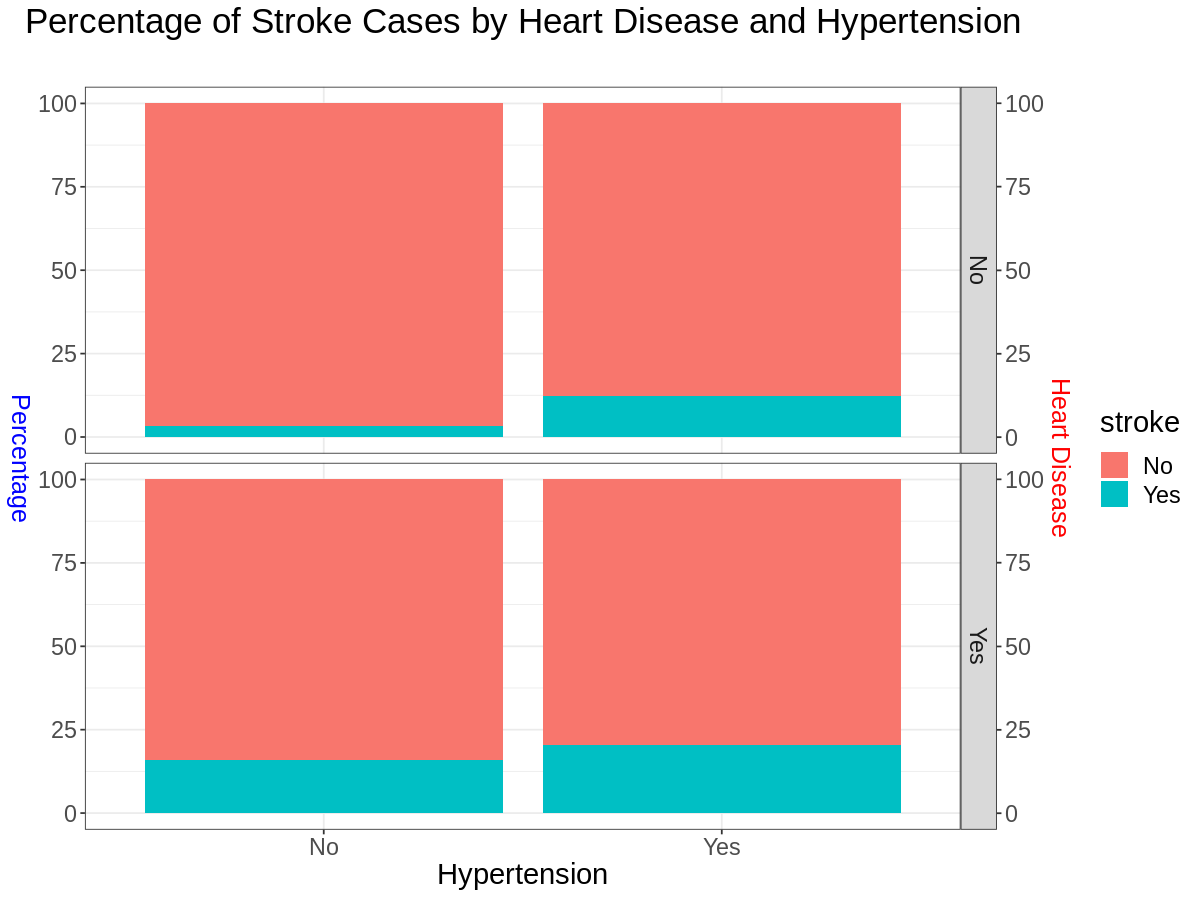

In [102]:
options(repr.plot.width = 10, repr.plot.height = 7.5) 

heartdisease_hypertension <- stroke %>%
  count(hypertension, stroke, heart_disease) %>%
  group_by(hypertension,heart_disease) %>%
  mutate(percentage = n / sum(n) * 100) %>%
  ungroup()

ggplot(heartdisease_hypertension, aes(x = hypertension, y = percentage, fill = stroke)) +
  geom_bar(stat = "identity") +
  labs(x = "Hypertension", y = "", title = "Percentage of Stroke Cases by Heart Disease and Hypertension\n") +
  facet_grid(heart_disease ~ .) +
  theme_bw() +
  theme(
    axis.title.y.right = element_text(color = "red", size = 15, angle = -90, vjust = 0.5),
    axis.title.y.left = element_text(color = "blue", size = 15, angle = -90, vjust = 0.5)
  ) +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5))+
  scale_y_continuous(
    name = "Percentage",
    sec.axis = sec_axis(~ ., name = "Heart Disease")
  )


In general, individuals without hypertension and heart disease have the lowest likelihood of having had a stroke, with a prevalence of less than 5%. However, those with both hypertension and heart disease exhibit the highest percentage, around 18%, of stroke cases. Participants with only heart disease have a lower likelihood, less than 18%, while those with only hypertension have an approximate 13% likelihood of having had a stroke.

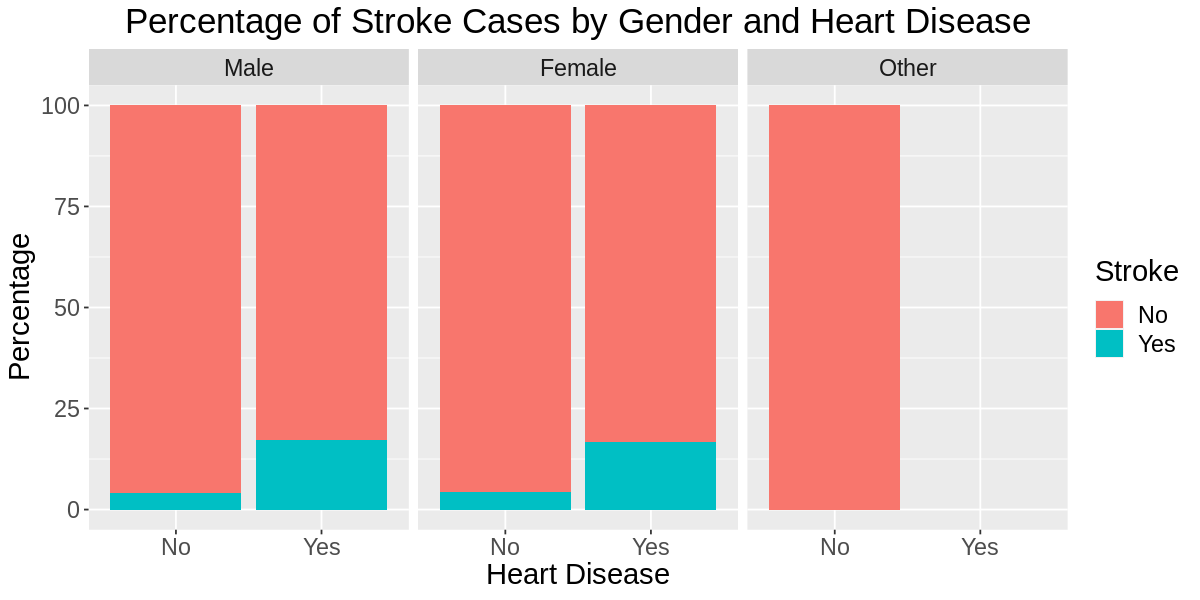

In [103]:
options(repr.plot.width = 10, repr.plot.height = 5) 

heartdisease_gender <- stroke %>%
  count(gender, heart_disease, stroke) %>%
  group_by(gender, heart_disease) %>%
  mutate(percentage = n / sum(n) * 100)

# Create the plot
stroke_gender_plot <- heartdisease_gender %>%
  ggplot(aes(x = heart_disease, y = percentage, fill = stroke)) +
  geom_bar(stat = "identity") +
  facet_wrap(~ gender) +
  labs(x = "Heart Disease", y = "Percentage", fill = "Stroke", title = "Percentage of Stroke Cases by Gender and Heart Disease") +
  theme(text = element_text(size = 17.5), plot.title = element_text(hjust = 0.5))

# Display the plot
print(stroke_gender_plot)

While there isn't a strong association between heart disease and gender, both male and female participants with heart disease have a notably higher likelihood of having had a stroke compared to those without a heart condition.

Warning message:
“Removed 201 rows containing missing values (geom_point).”


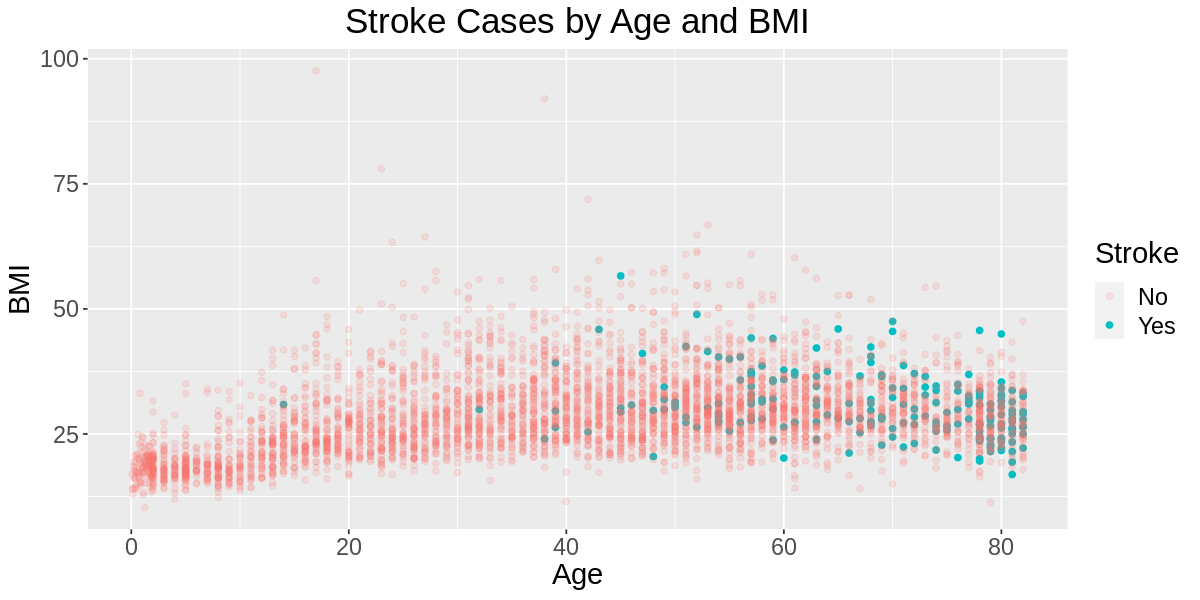

In [104]:
age_bmi <- stroke %>%
  ggplot(aes(x = age, y = bmi, colour = stroke)) +
  geom_point() +
  labs(x = "Age", y = "BMI", color = "Stroke", title = "Stroke Cases by Age and BMI") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5))+
  scale_color_manual(values = alpha(c("No" = "#F8766D", "Yes" = "#00BFC4"), c(0.15, 1.0)))

age_bmi

Age seems to be the main predictor of stroke when BMI is roughly under 25. However, this is not for a majority of the cases. Most cases where participants have suffered a stroke, they tend to be above 50 years old and have a BMI of greater than 25.

Warning message:
“Removed 201 rows containing missing values (geom_point).”


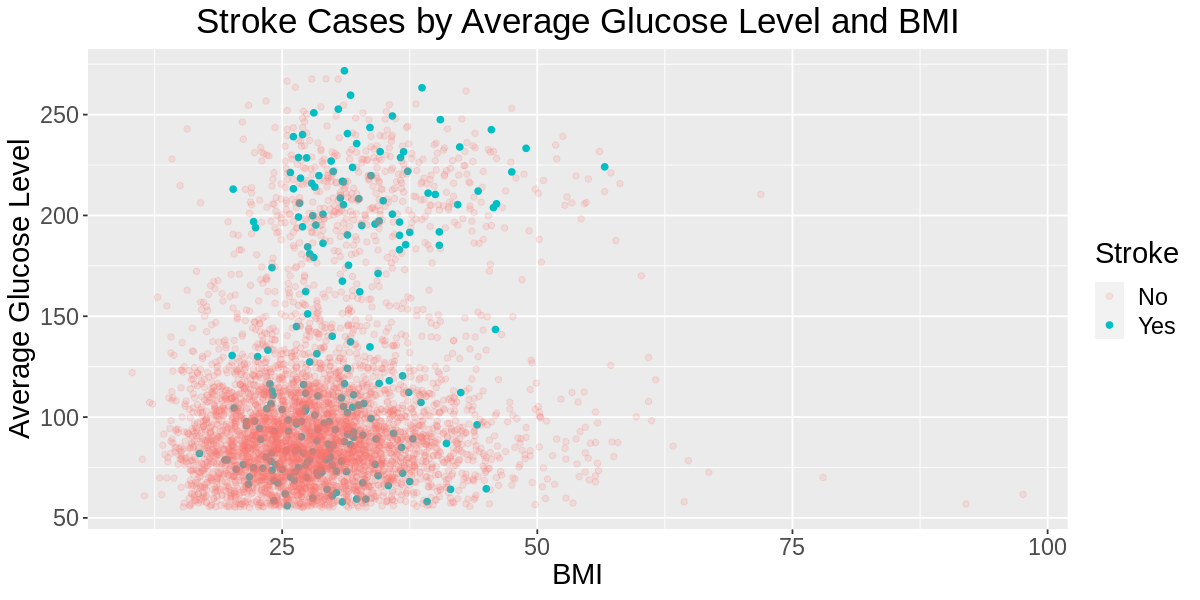

In [105]:
glucose_bmi <- stroke %>%
  ggplot(aes(x = bmi, y = avg_glucose_level, colour = stroke)) +
  geom_point() +
  labs(x = "BMI", y = "Average Glucose Level", color = "Stroke", title = "Stroke Cases by Average Glucose Level and BMI") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5)) +
  scale_color_manual(values = alpha(c("No" = "#F8766D", "Yes" = "#00BFC4"), c(0.15, 1.0)))

glucose_bmi

Our analysis suggests that participants with a BMI of 25 or higher make up a majority  of the instances of strokes regardless of average glucose levels. The majority of participants who did not suffer a stroke had average glucose levels  of under 150. This tells us that BMI is a stronger predictor of whether someone had a stroke, but maintaining glucose levels at under 150 and BMI under 25 may reduce the risks of stroke. 

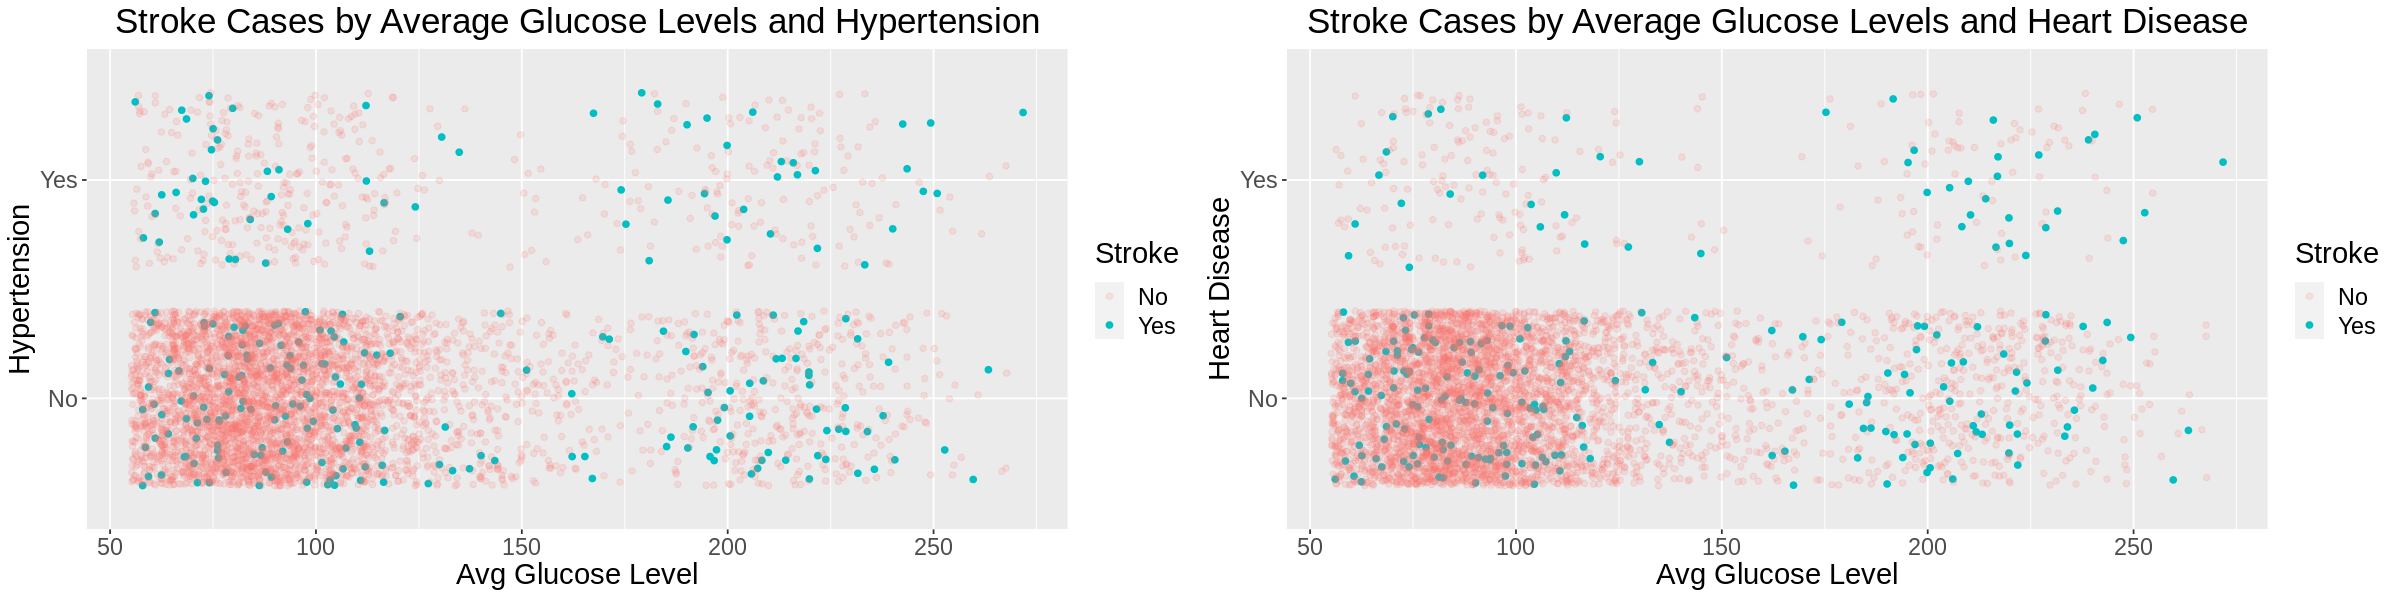

In [106]:
glucose_hypertension <- stroke %>%
  ggplot(aes(x = avg_glucose_level, y = hypertension, colour = stroke)) +
  geom_jitter() +
  labs(x = "Avg Glucose Level", y = "Hypertension", color = "Stroke", title = "Stroke Cases by Average Glucose Levels and Hypertension") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5)) +
  scale_color_manual(values = alpha(c("No" = "#F8766D", "Yes" = "#00BFC4"), c(0.15, 1.0)))

glucose_heartdisease <- stroke %>%
  ggplot(aes(x = avg_glucose_level, y = heart_disease, colour = stroke)) +
  geom_jitter() +
  labs(x = "Avg Glucose Level", y = "Heart Disease", color = "Stroke", title = "Stroke Cases by Average Glucose Levels and Heart Disease") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5)) +
  scale_color_manual(values = alpha(c("No" = "#F8766D", "Yes" = "#00BFC4"), c(0.15, 1.0)))

options(repr.plot.width = 20, repr.plot.height = 5) 

grid.arrange(glucose_hypertension, glucose_heartdisease, ncol = 2)

##### Stroke Cases by Average Glucose Levels and Hypertension:
Most cases where the participant did not suffer a stroke are associated with not suffering hypertension and have an average glucose level of less than 125. Regardless of glucose levels, those who have had hypertension experience a similar percentage of stroke cases, suggesting that once someone has hypertension, glucose levels may not matter for stroke prediction. Those who have not had hypertension and have high average glucose levels (>175), had the highest percentage of strokes, but not by a significant margin compared to those who have hypertension, regardless of glucose levels.


##### Stroke Cases by Average Glucose Levels and Heart Disease:
Most cases where the participant did not suffer a stroke are associated with not suffering heart disease and have an average glucose level of less than 125. Regardless of glucose levels, those who have had heart disease experience a similar percentage of stroke cases, suggesting that once someone has heart disease, glucose levels may not matter for stroke prediction. However, we do have a lack of stroke cases in those who have an average glucose level around 150, who have suffered heart disease. Those who have not had heart disease and have high average glucose levels (>175), had the highest percentage of strokes. 


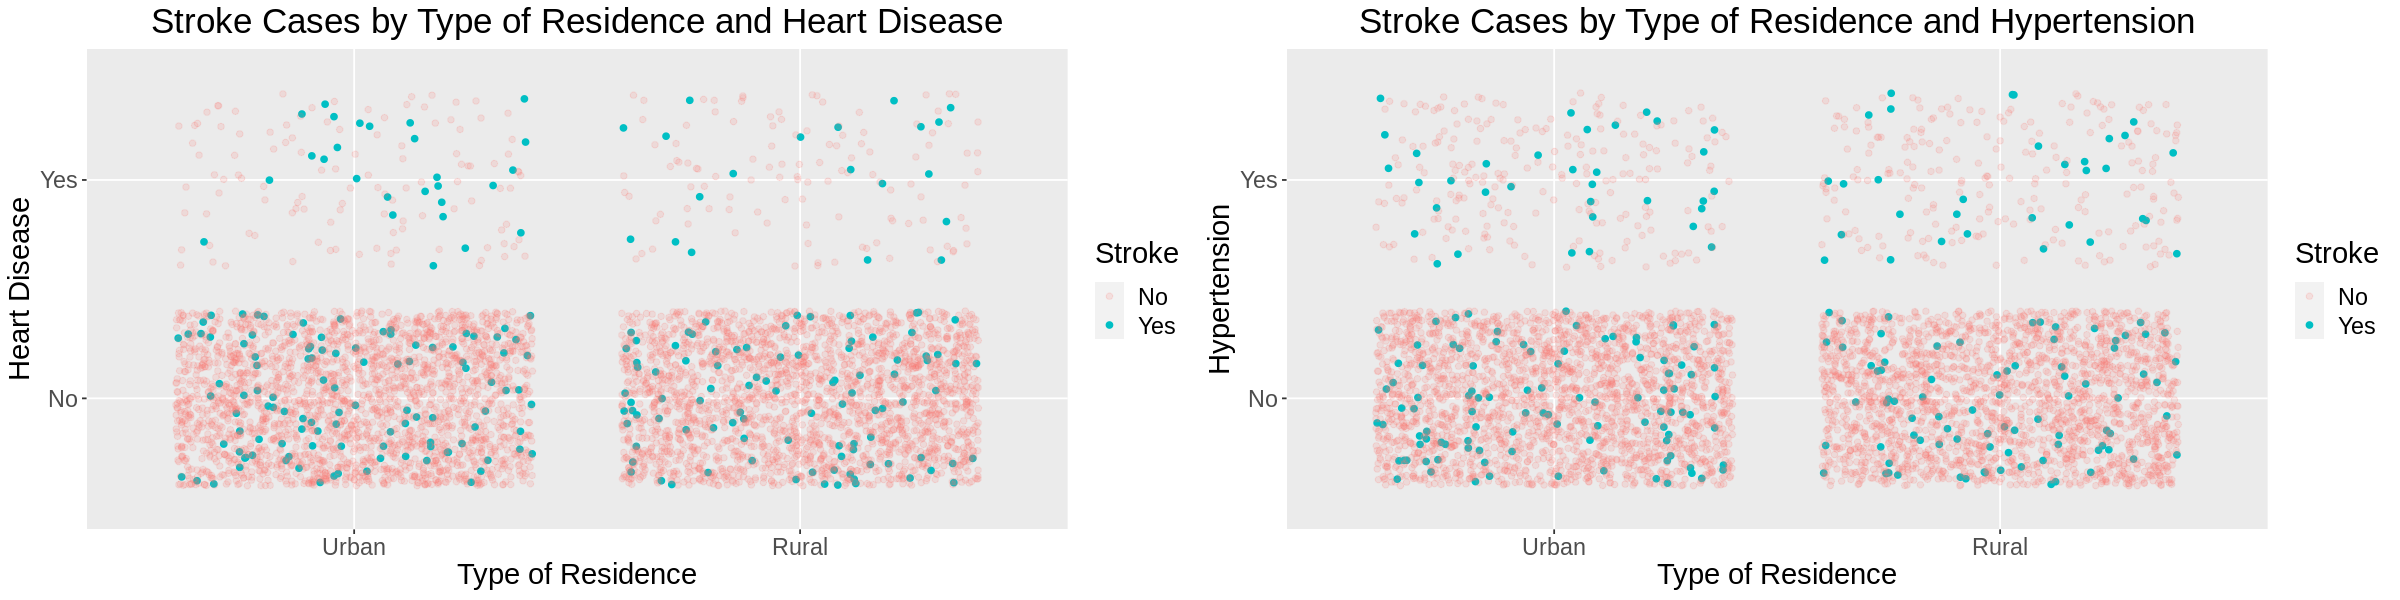

In [107]:
options(repr.plot.width = 10, repr.plot.height = 5) 

residence_heartdisease <- stroke %>%
  ggplot(aes(x = residence_type, y = heart_disease, colour = stroke)) +
  geom_jitter() +
  labs(x = "Type of Residence", y = "Heart Disease", color = "Stroke", title = "Stroke Cases by Type of Residence and Heart Disease") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5)) +
  scale_color_manual(values = alpha(c("No" = "#F8766D", "Yes" = "#00BFC4"), c(0.15, 1.0)))

residence_hypertension <- stroke %>%
  ggplot(aes(x = residence_type, y = hypertension, colour = stroke)) +
  geom_jitter() +
  labs(x = "Type of Residence", y = "Hypertension", color = "Stroke", title = "Stroke Cases by Type of Residence and Hypertension") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5)) +
  scale_color_manual(values = alpha(c("No" = "#F8766D", "Yes" = "#00BFC4"), c(0.15, 1.0)))

options(repr.plot.width = 20, repr.plot.height = 5) 

grid.arrange(residence_heartdisease, residence_hypertension, ncol = 2)


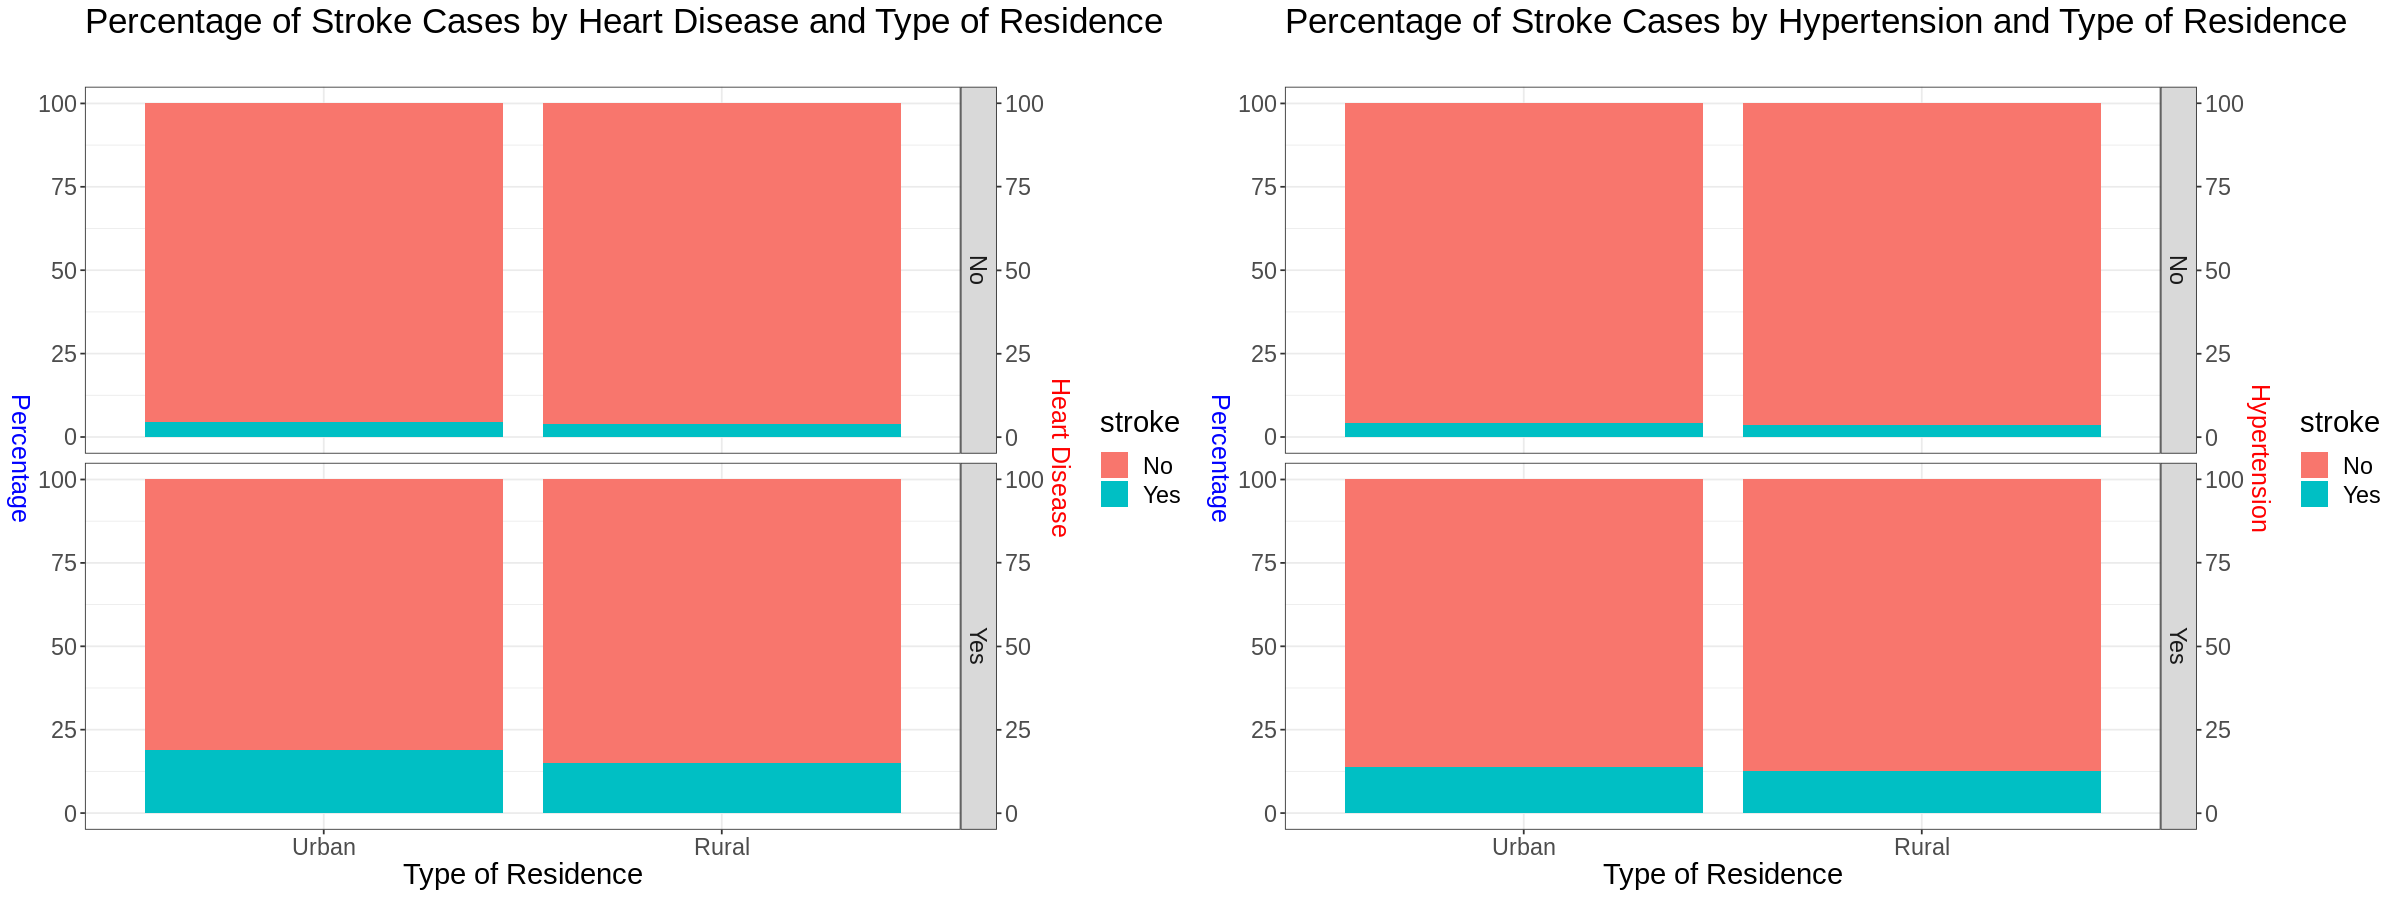

In [113]:
options(repr.plot.width = 10, repr.plot.height = 7.5) 

heartdisease_residence <- stroke %>%
  count(residence_type, stroke, heart_disease) %>%
  group_by(residence_type,heart_disease) %>%
  mutate(percentage = n / sum(n) * 100) %>%
  ungroup()

heartdisease_residence <- heartdisease_residence %>%
    ggplot(aes(x = residence_type, y = percentage, fill = stroke)) +
      geom_bar(stat = "identity") +
      labs(x = "Type of Residence", y = "", title = "Percentage of Stroke Cases by Heart Disease and Type of Residence\n") +
      facet_grid(heart_disease ~ .) +
      theme_bw() +
      theme(
        axis.title.y.right = element_text(color = "red", size = 15, angle = -90, vjust = 0.5),
        axis.title.y.left = element_text(color = "blue", size = 15, angle = -90, vjust = 0.5)
      ) +
      theme(text = element_text(size = 17.5),
        plot.title = element_text(hjust = 0))+
      scale_y_continuous(
        name = "Percentage",
        sec.axis = sec_axis(~ ., name = "Heart Disease")
      )

hypertension_residence <- stroke %>%
  count(residence_type, stroke, hypertension) %>%
  group_by(residence_type,hypertension) %>%
  mutate(percentage = n / sum(n) * 100) %>%
  ungroup()

hypertension_residence <- hypertension_residence %>%
    ggplot(aes(x = residence_type, y = percentage, fill = stroke)) +
      geom_bar(stat = "identity") +
      labs(x = "Type of Residence", y = "", title = "Percentage of Stroke Cases by Hypertension and Type of Residence\n") +
      facet_grid(hypertension ~ .) +
      theme_bw() +
      theme(
        axis.title.y.right = element_text(color = "red", size = 15, angle = -90, vjust = 0.5),
        axis.title.y.left = element_text(color = "blue", size = 15, angle = -90, vjust = 0.5)
      ) +
      theme(text = element_text(size = 17.5),
        plot.title = element_text(hjust = 0))+
      scale_y_continuous(
        name = "Percentage",
        sec.axis = sec_axis(~ ., name = "Hypertension")
      )

options(repr.plot.width = 20, repr.plot.height = 7.5) 

grid.arrange(heartdisease_residence, hypertension_residence, ncol = 2)

##### Stroke Cases by Type of Residence and Heart Disease
The instances of stroke are roughly equal for those who have not experienced heart disease, regardless of their type of residence. Cases of strokes are also roughly equal between those who have experienced heart disease, regardless of their residence type. Most cases of no stroke are prevalent in those who did not experience heart disease. However,  it does appear that there is a higher occurrence of strokes for those who have not experienced heart disease. 

##### Stroke Cases by Residence Type and Hypertension
Regardless of one’s residence type, cases of strokes are roughly equal when one experiences hypertension. The prevalence of strokes in those who did not have hypertension is also in both urban and rural areas, and most cases of no stroke are present in those who don’t have hypertension. 

This suggests that hypertension and heart disease are likely a stronger predictor of stroke than the type of residence one resides in.
